<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_04_01_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [1]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 17.5 MB/s eta 0:00:00


In [3]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 245 (delta 8), reused 1 (delta 1), pack-reused 225
Receiving objects: 100% (245/245), 7.11 MiB | 10.29 MiB/s, done.
Resolving deltas: 100% (114/114), done.


## 2.2 Setup of Data Collection Functions

In [4]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [5]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)
print(full_finance.head(20))

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1428 non-null   datetime64[ns]
 1   open       1428 non-null   float64       
 2   high       1428 non-null   float64       
 3   low        1428 non-null   float64       
 4   close      1428 non-null   float64       
 5   adj_close  1428 non-null   float64       
 6   volume     1428 non-null   int64         
 7   ticker     1428 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.4+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [6]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
  #check for outstanding NA values
  print(df['score'].isna().sum())
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

0
0
0
0
0
             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [7]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]

print(frames[1])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1410 non-null   datetime64[ns]
 1   score   1410 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 1428 to 2855
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1428 non-null   datetime64[ns]
 1   open        1428 non-null   float64       
 2   high        1428 non-null   float64       
 3   low         1428 non-null   float64       
 4   close       1428 non-null   float64       
 5   adj_close   1428 non-null   float64       
 6   volume      1428 non-null   int64         
 7   ticker      1428 non-null   object        
 8   target      1428 non-null   float64       
 9   10mda     

<ipython-input-7-bbe5864b1c94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-7-bbe5864b1c94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-7-bbe5864b1c94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

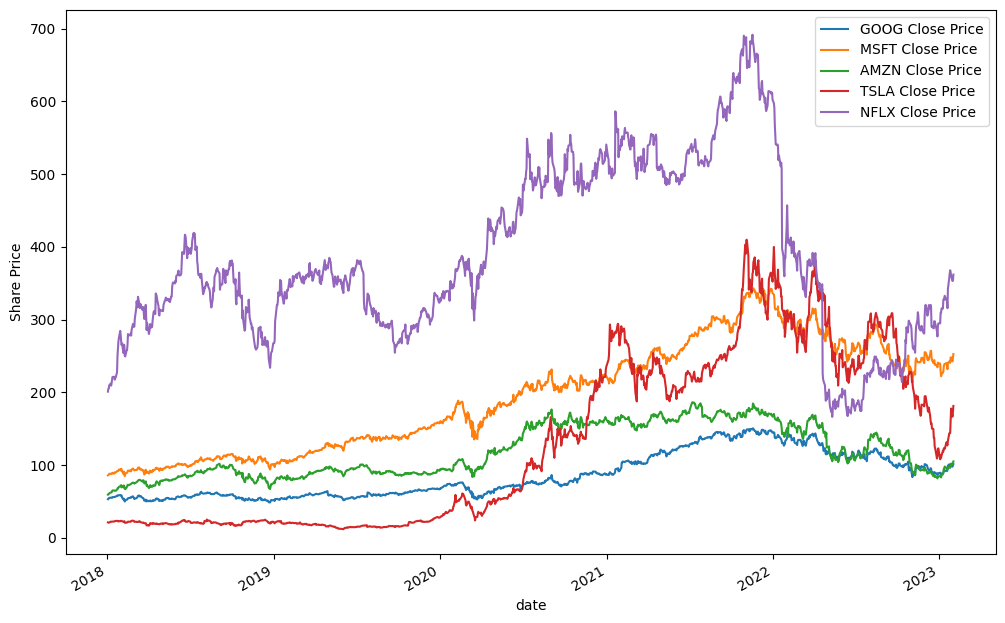

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/indexes/base.py", line 3629, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'headline'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e9dd5037dc9d>", line 15, in <cell line: 14>
    frame['average headlines'] = frame['headline'].rolling(20).mean()

TypeError: ignored

In [8]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (12, 8))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


## 3.3 Scale Data and Configure Training/Test Datasets 

In [59]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [10]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 33s]
val_loss: 0.05778544396162033

Best val_loss So Far: 0.0009160652989521623
Total elapsed time: 00h 29m 08s
36/36 [==============================] - 1s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
[0.0019146044505760074, 0.0019146044505760074]
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 20, 'dropout2': 0.7, 'neurons_hidden2': 50, 'dropout3': 0.1, 'neurons_hidden3': 50}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [11]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


In [55]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape


4/4 [==============================] - 0s 5ms/step


(127, 1)

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [45]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [35]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 0s 4ms/step


(1270, 1)

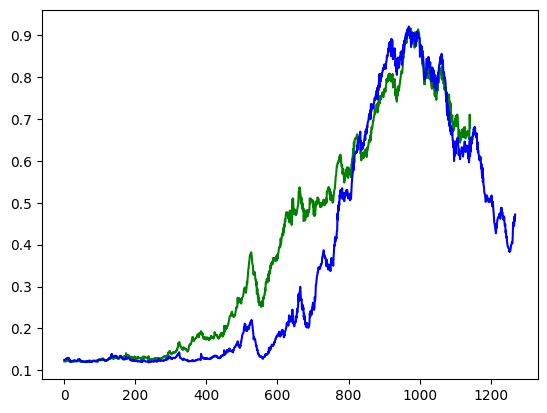

In [36]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()


##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [12]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [13]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/t0er457k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ofdn2dte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17439', 'data', 'file=/tmp/tmpdf26z35w/t0er457k.json', 'init=/tmp/tmpdf26z35w/ofdn2dte.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelpbyp65ql/prophet_model-20230401142054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/u_cr36cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/4ki__0_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91151', 'data', 'file=/tmp/tmpdf26z35w/u_cr36cm.json', 'init=/tmp/tmpdf26z35w/4ki__0_b.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelx01l9v46/prophet_model-20230401142055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/rkpn4c96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/v37svaky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/yozwcx39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87784', 'data', 'file=/tmp/tmpdf26z35w/e365d3w0.json', 'init=/tmp/tmpdf26z35w/yozwcx39.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model8vlgf9om/prophet_model-20230401142225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/9y48er1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/e27mvjv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9479', 'data', 'file=/tmp/tmpdf26z35w/9y48er1e.json', 'init=/tmp/tmpdf26z35w/e27mvjv4.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelw5lhzvk5/prophet_model-20230401142226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/e1c2509s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/hcl0o72l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


14:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/aiuf6z8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ruv6etbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48813', 'data', 'file=/tmp/tmpdf26z35w/aiuf6z8a.json', 'init=/tmp/tmpdf26z35w/ruv6etbo.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model1ryh46n5/prophet_model-20230401142321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ewytette.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kpa9wxlm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


14:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/7wxd1qsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ynjjkggp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43920', 'data', 'file=/tmp/tmpdf26z35w/7wxd1qsk.json', 'init=/tmp/tmpdf26z35w/ynjjkggp.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelrwat_lut/prophet_model-20230401142419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/1v31vume.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kctmx3w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/21zwdilm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zgd0w4h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26082', 'data', 'file=/tmp/tmpdf26z35w/21zwdilm.json', 'init=/tmp/tmpdf26z35w/zgd0w4h5.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelwyzdojew/prophet_model-20230401142521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/88ia88u5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/z2luslt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:26:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/j2t0ddn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g8fascsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28609', 'data', 'file=/tmp/tmpdf26z35w/j2t0ddn2.json', 'init=/tmp/tmpdf26z35w/g8fascsw.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeld4vrf36v/prophet_model-20230401142625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/o8vrigr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/680pu3qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


14:27:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/wovu70s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/z4gybhzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16370', 'data', 'file=/tmp/tmpdf26z35w/wovu70s2.json', 'init=/tmp/tmpdf26z35w/z4gybhzq.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model4rr_6ugs/prophet_model-20230401142752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ipwrjq7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kw86xr5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


14:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/22i_8bz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zyy2nxug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18818', 'data', 'file=/tmp/tmpdf26z35w/22i_8bz6.json', 'init=/tmp/tmpdf26z35w/zyy2nxug.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelzwfo2qe4/prophet_model-20230401142950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/toz6dm4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/rl0nue96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/8aptnk2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67195', 'data', 'file=/tmp/tmpdf26z35w/rsoa3sb9.json', 'init=/tmp/tmpdf26z35w/8aptnk2r.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelg24kcl8w/prophet_model-20230401143150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/x4xo43a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/9p4e9_ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53107', 'data', 'file=/tmp/tmpdf26z35w/x4xo43a1.json', 'init=/tmp/tmpdf26z35w/9p4e9_ba.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeljd4t3gr9/prophet_model-20230401143152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/cc5zocv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ay7ykt_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/33im4ws2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2541', 'data', 'file=/tmp/tmpdf26z35w/x6qch2tr.json', 'init=/tmp/tmpdf26z35w/33im4ws2.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelof4p1tfq/prophet_model-20230401143352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/h5q27j0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/60t5hjiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27166', 'data', 'file=/tmp/tmpdf26z35w/h5q27j0_.json', 'init=/tmp/tmpdf26z35w/60t5hjiu.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model7vwhhrkv/prophet_model-20230401143354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/vj6a8kah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2ona776r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/w0sj6g9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3j7curi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7596', 'data', 'file=/tmp/tmpdf26z35w/w0sj6g9d.json', 'init=/tmp/tmpdf26z35w/3j7curi3.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model3bbe90u0/prophet_model-20230401143601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/_87zyy95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/q0rth34t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/r965n7go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/1dg5o2oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98923', 'data', 'file=/tmp/tmpdf26z35w/r965n7go.json', 'init=/tmp/tmpdf26z35w/1dg5o2oj.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelst8chku3/prophet_model-20230401143820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/vf1mn_qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/4y32of6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zv59p558.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9797', 'data', 'file=/tmp/tmpdf26z35w/qvque2l5.json', 'init=/tmp/tmpdf26z35w/zv59p558.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelv2zfai6h/prophet_model-20230401144157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/fzw6k6w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2_r45tf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58045', 'data', 'file=/tmp/tmpdf26z35w/fzw6k6w6.json', 'init=/tmp/tmpdf26z35w/2_r45tf3.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelv9mj14zl/prophet_model-20230401144159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/s34d1dqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/iq5tl41a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


14:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/afue2qmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g5hibljd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97626', 'data', 'file=/tmp/tmpdf26z35w/afue2qmr.json', 'init=/tmp/tmpdf26z35w/g5hibljd.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelf5v6v8pi/prophet_model-20230401144444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/fsbhnucr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zulw_erw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/lm2sa070.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38639', 'data', 'file=/tmp/tmpdf26z35w/oudc45eb.json', 'init=/tmp/tmpdf26z35w/lm2sa070.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelczcd96ir/prophet_model-20230401144725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/i_gk_p1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/nnktmrw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90222', 'data', 'file=/tmp/tmpdf26z35w/i_gk_p1t.json', 'init=/tmp/tmpdf26z35w/nnktmrw6.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeltym4fu2i/prophet_model-20230401144726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/tx9tr22g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3byugpf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


14:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/v75lrfek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/eyvln51d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35408', 'data', 'file=/tmp/tmpdf26z35w/v75lrfek.json', 'init=/tmp/tmpdf26z35w/eyvln51d.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelkqqgm8yb/prophet_model-20230401145005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/mend8r8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g_sa8qm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2q17ept3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/5gjbn81g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38258', 'data', 'file=/tmp/tmpdf26z35w/2q17ept3.json', 'init=/tmp/tmpdf26z35w/5gjbn81g.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model5ykjzp3_/prophet_model-20230401145243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/5hjy33hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2xjxaw4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3i5e662e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/71__gz9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56782', 'data', 'file=/tmp/tmpdf26z35w/3i5e662e.json', 'init=/tmp/tmpdf26z35w/71__gz9b.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model_aysgm9q/prophet_model-20230401145535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/soj4jwhf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ffuh4rka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Minimum cross-validation error: 185.1688513042688


### 4.3.1 Forecasting with Prophet

In [15]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [16]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/u23gk3ts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/e0hrbcoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36433', 'data', 'file=/tmp/tmpis1m8_54/u23gk3ts.json', 'init=/tmp/tmpis1m8_54/e0hrbcoy.json', 'output', 'file=/tmp/tmpis1m8_54/prophet_modelzhlfq788/prophet_model-20230406173916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/hqoaxg65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/s7jo04_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48224', 'data', 'file=/tmp/tmpis1m8_54/hqoaxg65.json', 'init=/tmp/tmpis1m8_54/s7jo04_s.json', 'output', 'file=/tmp/tmpis1m8_54/prophet_model0o_vki07/prophet_model-20230406173919.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:39:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/6arg5sph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/jc1vhhpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [17]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/24kif21q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/g47e42jk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26684', 'data', 'file=/tmp/tmpis1m8_54/24kif21q.json', 'init=/tmp/tmpis1m8_54/g47e42jk.json', 'output', 'file=/tmp/tmpis1m8_54/prophet_modelke8wopoz/prophet_model-20230406174520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/1sagialo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/xhek16cs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18264', 'data', 'file=/tmp/tmpis1m8_54/1sagialo.json', 'init=/tmp/tmpis1m8_54/xhek16cs.json', 'output', 'file=/tmp/tmpis1m8_54/prophet_modelnso43g_z/prophet_model-20230406174523.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/cpnqxzkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpis1m8_54/_sa_e6r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [46]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [60]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [61]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'MSFT_PROPHET':np.array(msft_train_data),  'LSTM':LSTM_MSFT_yhat.flatten()}
msft_hybrid_df = pd.DataFrame(msft_hybrid)
#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()

reshaped_msft = msft_hybrid_df['MSFT_PROPHET'].to_numpy()
reshaped_msft= reshaped_msft.reshape(-1,1)

scaled_msft = scaler2.fit_transform(reshaped_msft)
msft_hybrid_df['MSFT_Pscaled'] = scaled_msft.flatten()
msft_hybrid_df=msft_hybrid_df.drop('MSFT_PROPHET', axis=1)

#verifying the transform
print("msft hybrid",msft_hybrid_df.shape)
#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))
print(y_train2.shape)

36/36 [==============================] - 0s 4ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
msft hybrid (1143, 2)
y_hybrid (1143, 1)
(1133, 1)


In [62]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 2s 9ms/step - loss: 0.2273 - mae: 0.3569
Epoch 2/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0766 - mae: 0.2231
Epoch 3/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0452 - mae: 0.1698
Epoch 4/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0243 - mae: 0.1252
Epoch 5/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0182 - mae: 0.1038
Epoch 6/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0137 - mae: 0.0924
Epoch 7/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0116 - mae: 0.0842
Epoch 8/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0105 - mae: 0.0800
Epoch 9/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0092 - mae: 0.0762
Epoch 10/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0081 - mae: 0.0700
Epoch 11/300
48/48 [==============================] - 0s 9ms/step - 

###4.4.2 LOSS and MAE

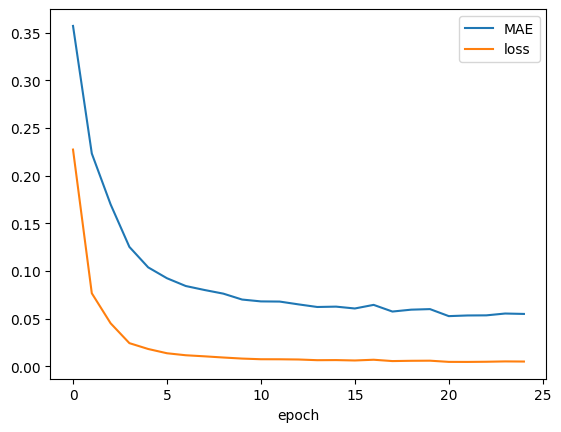

In [63]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [37]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [67]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 0s 6ms/step


In [74]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 0s 5ms/step


In [94]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)

    return mse.result().numpy(), mae.result().numpy()

In [95]:
print(GOOG_y_test.shape, GOOG_predictions.shape)
mse, mae = compute_metrics(GOOG_y_test, GOOG_predictions)
print(mae)

(1260, 1) (1260, 1)
0.063952096


###4.4.5 Predicted vs Actual Price

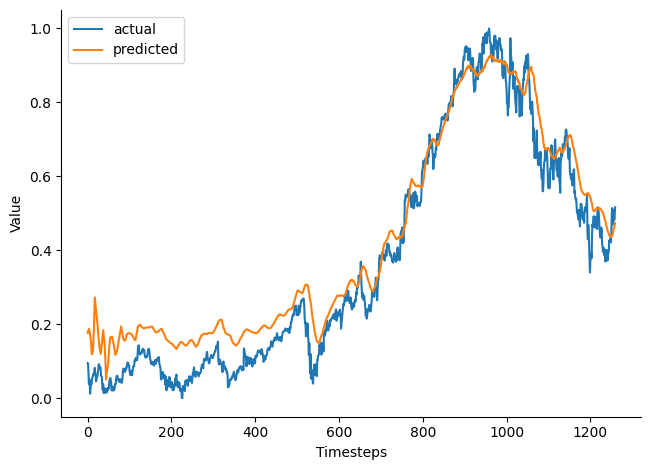

In [98]:

plt.plot(GOOG_y_test, label="actual")
plt.plot(GOOG_predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

In [ ]:
GOOG_scaler = 
MSFT_scaler = 

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [30]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


52/53 [============================>.] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.0185

53/53 [==============================] - 2s 10ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 10ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 4/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 6/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 7/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 8/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 12/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 13/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 14/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 15/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 16/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 17/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 18/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 19/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 20/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 21/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 22/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 24/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 26/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 27/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 18ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 30/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 32/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 33/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 36/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 37/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 38/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 39/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 40/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 41/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 43/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 46/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 47/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 48/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 49/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 50/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 51/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 52/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 53/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 54/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 55/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 57/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 58/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 59/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 60/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 61/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 63/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 65/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 66/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 24ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 20ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 25ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 2s 44ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 20ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 76/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 77/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 78/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 79/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 81/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 82/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 83/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 84/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 85/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 87/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 88/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 90/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 91/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 92/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 94/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 21ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 98/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 100/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 103/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 105/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 109/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 110/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 111/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 113/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 114/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 115/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 119/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 120/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 121/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 123/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 124/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 125/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 129/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 131/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 132/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 133/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 134/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 135/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 136/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 138/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 140/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 145/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 146/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 147/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 148/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 25ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 151/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 153/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 154/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 155/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 159/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 160/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 161/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 164/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 169/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0263 - mean_squared_error: 0.0263

53/53 [==============================] - 1s 11ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 171/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0665 - mean_squared_error: 0.0665

53/53 [==============================] - 1s 11ms/step - loss: 0.0654 - mean_squared_error: 0.0654
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0663 - mean_squared_error: 0.0663

53/53 [==============================] - 1s 13ms/step - loss: 0.0651 - mean_squared_error: 0.0651
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0660 - mean_squared_error: 0.0660

53/53 [==============================] - 1s 12ms/step - loss: 0.0660 - mean_squared_error: 0.0660
Epoch 174/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0669 - mean_squared_error: 0.0669

53/53 [==============================] - 1s 11ms/step - loss: 0.0656 - mean_squared_error: 0.0656
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0816 - mean_squared_error: 0.0816

53/53 [==============================] - 1s 11ms/step - loss: 0.0820 - mean_squared_error: 0.0820
Epoch 176/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0986 - mean_squared_error: 0.0986

53/53 [==============================] - 1s 11ms/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 177/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.0424

53/53 [==============================] - 1s 12ms/step - loss: 0.0398 - mean_squared_error: 0.0398
Epoch 178/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

53/53 [==============================] - 1s 12ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 179/200
53/53 [==============================] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

53/53 [==============================] - 1s 11ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 180/200
52/53 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 11ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 11ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 16ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 16ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 18ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 186/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 17ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 188/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 190/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 192/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 194/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 196/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 197/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 198/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1/200
52/53 [============================>.] - ETA: 0s - loss: 0.0210 - mean_squared_error: 0.0210

53/53 [==============================] - 4s 21ms/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.0113

53/53 [==============================] - 1s 17ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 12ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 4/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 11ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 11ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 6/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 12ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 7/200
53/53 [==============================] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 8/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 11ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 9/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 10ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 12/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 18ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 16/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 18/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 19/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 21/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 22/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 24/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 27/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 28/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 29/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 30/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 31/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 33/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 37/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 38/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 40/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 41/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 42/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 45/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 46/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 53/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 56/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 62/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 63/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 64/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 65/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 66/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 67/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 68/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 69/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 70/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 73/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 74/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 76/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 79/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 81/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 83/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 85/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 86/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 2s 30ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 88/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 89/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 90/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 92/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 94/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 95/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 97/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 106/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 108/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 110/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 112/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 114/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 115/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 117/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 118/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 121/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 123/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 125/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 127/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 130/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 131/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 133/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 135/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 136/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 138/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 141/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 142/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 144/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 145/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 147/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 148/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 149/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 153/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 155/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 156/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 157/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 158/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 159/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 163/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 164/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 165/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 166/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 168/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 169/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 171/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 173/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 174/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 176/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 178/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 180/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 184/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 185/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 188/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 189/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 190/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 191/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 193/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 14ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0634 - mean_squared_error: 0.0634

53/53 [==============================] - 1s 15ms/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 198/200
50/53 [===========================>..] - ETA: 0s - loss: 0.1895 - mean_squared_error: 0.1895

53/53 [==============================] - 1s 15ms/step - loss: 0.1930 - mean_squared_error: 0.1930
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.2760 - mean_squared_error: 0.2760

53/53 [==============================] - 1s 16ms/step - loss: 0.2760 - mean_squared_error: 0.2760
Epoch 200/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2772 - mean_squared_error: 0.2772

53/53 [==============================] - 1s 18ms/step - loss: 0.2759 - mean_squared_error: 0.2759
Epoch 1/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0234 - mean_squared_error: 0.0234

53/53 [==============================] - 2s 12ms/step - loss: 0.0229 - mean_squared_error: 0.0229
Epoch 2/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

53/53 [==============================] - 1s 10ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 3/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 4/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 6/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 7/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 8/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 10/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 11/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 14/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 15/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 16/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 17/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 21/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 23/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 24/200
53/53 [==============================] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 25/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0143 - mean_squared_error: 0.0143

53/53 [==============================] - 1s 11ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 26/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120

53/53 [==============================] - 1s 12ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 28/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 30/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 31/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 32/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 33/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 34/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 36/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 37/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 39/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 40/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 41/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 43/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 44/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 45/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 47/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 50/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 51/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 53/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 54/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 58/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 59/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 60/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 62/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 65/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 66/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 68/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 71/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 74/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 77/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 78/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 79/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 80/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 81/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 84/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 85/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 86/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 91/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 92/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 93/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 12ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 98/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 100/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 102/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 106/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 107/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 110/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 112/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 17ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

53/53 [==============================] - 1s 18ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 17ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 12ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 12ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 119/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 12ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 120/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

53/53 [==============================] - 1s 12ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 12ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 12ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 12ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 12ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 125/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 11ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

53/53 [==============================] - 1s 12ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 127/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 12ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 12ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 12ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 131/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 132/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 133/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 134/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 135/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 136/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 19ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 138/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 139/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 142/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 144/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 145/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 147/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 150/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 151/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 156/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 157/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 160/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 163/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 164/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 165/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 166/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 167/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 168/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 171/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 21ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 180/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 182/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 184/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 187/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 191/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 193/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 194/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 196/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 198/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 199/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 18ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 19ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0138 - mean_squared_error: 0.0138

53/53 [==============================] - 2s 11ms/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 13ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 3/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 4/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 7/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 8/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 15ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 13/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 14/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 18ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 19ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 17/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 20/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 21/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 22/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 23/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 28/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 29/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 30/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 32/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 33/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 34/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 18ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 37/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 39/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 19ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 40/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 46/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 47/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 49/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 50/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 53/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 55/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 62/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 63/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 20ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 64/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 65/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 69/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 70/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 74/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 76/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 81/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 83/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 85/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 86/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 87/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 88/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 89/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 91/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 92/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 93/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 94/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 97/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 99/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 101/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 107/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 111/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 114/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 115/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 116/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 117/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 120/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 124/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 127/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 19ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 130/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 132/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 134/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 136/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 137/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 138/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 141/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 146/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 148/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 153/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 156/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 157/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 163/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 164/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 165/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 171/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 172/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 173/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 176/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 180/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 182/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 183/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 186/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 187/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 191/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 193/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 194/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 198/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [31]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_train) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 0s 4ms/step
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


46/48 [===========================>..] - ETA: 0s - loss: 0.0380 - mean_squared_error: 0.0380

48/48 [==============================] - 2s 10ms/step - loss: 0.0379 - mean_squared_error: 0.0379
Epoch 2/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 3/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353

48/48 [==============================] - 0s 10ms/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 4/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 9ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 5/200
48/48 [==============================] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348

48/48 [==============================] - 0s 9ms/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 6/200
48/48 [==============================] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 7/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 8/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 9ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 9/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348

48/48 [==============================] - 0s 9ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 10/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 9ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 11/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 12/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 13/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 9ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 14/200
48/48 [==============================] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 0s 9ms/step - loss: 0.0323 - mean_squared_error: 0.0323
Epoch 15/200
48/48 [==============================] - ETA: 0s - loss: 0.0298 - mean_squared_error: 0.0298

48/48 [==============================] - 0s 9ms/step - loss: 0.0298 - mean_squared_error: 0.0298
Epoch 16/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 9ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 17/200
48/48 [==============================] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 13ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 18/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 14ms/step - loss: 0.0349 - mean_squared_error: 0.0349
Epoch 19/200
47/48 [============================>.] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 15ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 20/200
47/48 [============================>.] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 1s 15ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 21/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 15ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 22/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354

48/48 [==============================] - 1s 15ms/step - loss: 0.0349 - mean_squared_error: 0.0349
Epoch 23/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 24/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 9ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 25/200
48/48 [==============================] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 0s 9ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 26/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 9ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 27/200
48/48 [==============================] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 9ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 28/200
48/48 [==============================] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 29/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 30/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350

48/48 [==============================] - 0s 9ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 31/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 32/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 33/200
48/48 [==============================] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 34/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 9ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 35/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 36/200
48/48 [==============================] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 37/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 38/200
47/48 [============================>.] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 39/200
48/48 [==============================] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 40/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 41/200
47/48 [============================>.] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 42/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 43/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 44/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 12ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 45/200
47/48 [============================>.] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 15ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 46/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 47/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 15ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 48/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 16ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 49/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 15ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 50/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 51/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 52/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 53/200
47/48 [============================>.] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 54/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 55/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 56/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 57/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 58/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 59/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 60/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 11ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 61/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 62/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 63/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 11ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 64/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 65/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 66/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 9ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 67/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 68/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 69/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 70/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 71/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 14ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 72/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 73/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 74/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 75/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 76/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 15ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 77/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 78/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 9ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 79/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 80/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 9ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 81/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 82/200
48/48 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 9ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 83/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 84/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 85/200
47/48 [============================>.] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 86/200
48/48 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 87/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.0320

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 88/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 89/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 90/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 0s 9ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 91/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0318 - mean_squared_error: 0.0318

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 92/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 93/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 94/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 9ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 95/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 96/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 97/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 98/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 99/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 100/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 14ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 101/200
48/48 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 14ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 102/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 103/200
47/48 [============================>.] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 16ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 104/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 15ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 105/200
47/48 [============================>.] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 1s 11ms/step - loss: 0.0324 - mean_squared_error: 0.0324
Epoch 106/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 107/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 108/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 109/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 110/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 111/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 112/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 113/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 114/200
47/48 [============================>.] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 115/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 9ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 116/200
47/48 [============================>.] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 117/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 118/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 119/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 120/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 121/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 122/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 9ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 123/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 124/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 125/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 126/200
47/48 [============================>.] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 127/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 1s 14ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 128/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 15ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 129/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 130/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 15ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 131/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 15ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 132/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 133/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 134/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 135/200
47/48 [============================>.] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 11ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 136/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 137/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 11ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 138/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 139/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 140/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 1s 11ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 141/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.0320

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 142/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 143/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 144/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 145/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 146/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.0322

48/48 [==============================] - 1s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 147/200
47/48 [============================>.] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 148/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 149/200
47/48 [============================>.] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 150/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 151/200
48/48 [==============================] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 152/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 153/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 154/200
48/48 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 15ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 155/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 156/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 17ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 157/200
47/48 [============================>.] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 16ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 158/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 15ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 159/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 13ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 160/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 161/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 162/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0319 - mean_squared_error: 0.0319

48/48 [==============================] - 1s 11ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 163/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 164/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 165/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 166/200
48/48 [==============================] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 167/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 168/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 169/200
48/48 [==============================] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 9ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 170/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 9ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 171/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 172/200
47/48 [============================>.] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 9ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 173/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 174/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 9ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 175/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 176/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 177/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 178/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 0s 9ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 179/200
47/48 [============================>.] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324

48/48 [==============================] - 1s 11ms/step - loss: 0.0323 - mean_squared_error: 0.0323
Epoch 180/200
48/48 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 16ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 181/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.0322

48/48 [==============================] - 1s 14ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 182/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 14ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 183/200
47/48 [============================>.] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 13ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 184/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 185/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324

48/48 [==============================] - 1s 15ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 186/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324

48/48 [==============================] - 1s 14ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 187/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 1s 11ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 188/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.0322

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 189/200
47/48 [============================>.] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 190/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 191/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 192/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 193/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0324 - mean_squared_error: 0.0324
Epoch 194/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 195/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 196/200
48/48 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 9ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 197/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 198/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 199/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 9ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 200/200
47/48 [============================>.] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324

48/48 [==============================] - 0s 9ms/step - loss: 0.0327 - mean_squared_error: 0.0327


In [32]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [99]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 6ms/step


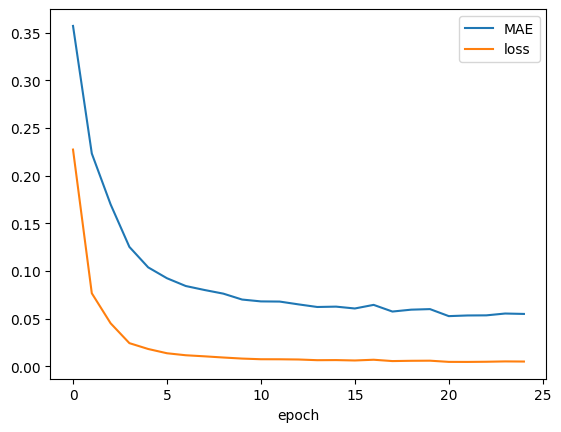

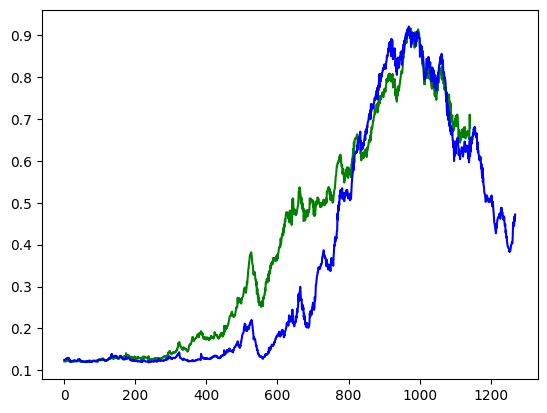

In [100]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# compare LSTM on trained on MSFT on predictions for Google
fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()